In [22]:
import pandas as pd

In [23]:
df1 = pd.read_csv("../data/raw/df1.csv", index_col=0)
df2 = pd.read_csv("../data/raw/df2.csv", index_col=0)
full_df = pd.concat([df1, df2], axis=1)

In [24]:
# usuwam bo uwazam, ze niepotrzebne  
full_df = full_df.drop(columns=["Over18", "EmployeeCount", "StandardHours"])

In [59]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4449 entries, 104 to 7979
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4449 non-null   float64
 1   BusinessTravel            4449 non-null   object 
 2   DailyRate                 4449 non-null   float64
 3   Department                4449 non-null   object 
 4   DistanceFromHome          4449 non-null   float64
 5   Education                 4449 non-null   float64
 6   EducationField            4449 non-null   object 
 7   EnvironmentSatisfaction   4449 non-null   float64
 8   Gender                    4449 non-null   object 
 9   HourlyRate                4449 non-null   float64
 10  JobInvolvement            4449 non-null   float64
 11  JobLevel                  4449 non-null   float64
 12  JobRole                   4449 non-null   object 
 13  JobSatisfaction           4449 non-null   float64
 14  Marita

In [25]:
# kolumny w ktorych byly jakies kosmiczne wartosci 
rows_to_drop = full_df.loc[
    (full_df["Age"] > 100) | 
    (full_df["DistanceFromHome"] > 100) |
    (full_df["TotalWorkingYears"] > 100) |
    (full_df["YearsAtCompany"] > 100) |
    (full_df["YearsInCurrentRole"] > 100) |
    (full_df["YearsSinceLastPromotion"] > 100) |
    (full_df["YearsWithCurrManager"] > 100)
    ].index

# dataframe bez outliers, ale zredukowany o polowe
df = full_df.drop(rows_to_drop)

In [26]:
# dla ułatwienia tutaj wypelnie zero w attrition column
df.Attrition.fillna(df.Attrition.value_counts().index[0], inplace=True)
df.Attrition = df.Attrition.replace(["No", "Yes"], [0, 1])
df.Attrition.unique()

array([0, 1])

In [27]:
obj_col = df.select_dtypes(exclude="number").columns
for col in obj_col:
    df[col] = df[col].astype("category")

In [28]:
float_col = df.select_dtypes(include="float64")
for col in float_col:
    df[col] = df[col].astype("int")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2498 entries, 104 to 7963
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       2498 non-null   int64   
 1   BusinessTravel            2498 non-null   category
 2   DailyRate                 2498 non-null   int64   
 3   Department                2498 non-null   category
 4   DistanceFromHome          2498 non-null   int64   
 5   Education                 2498 non-null   int64   
 6   EducationField            2498 non-null   category
 7   EnvironmentSatisfaction   2498 non-null   int64   
 8   Gender                    2498 non-null   category
 9   HourlyRate                2498 non-null   int64   
 10  JobInvolvement            2498 non-null   int64   
 11  JobLevel                  2498 non-null   int64   
 12  JobRole                   2498 non-null   category
 13  JobSatisfaction           2498 non-null   int6

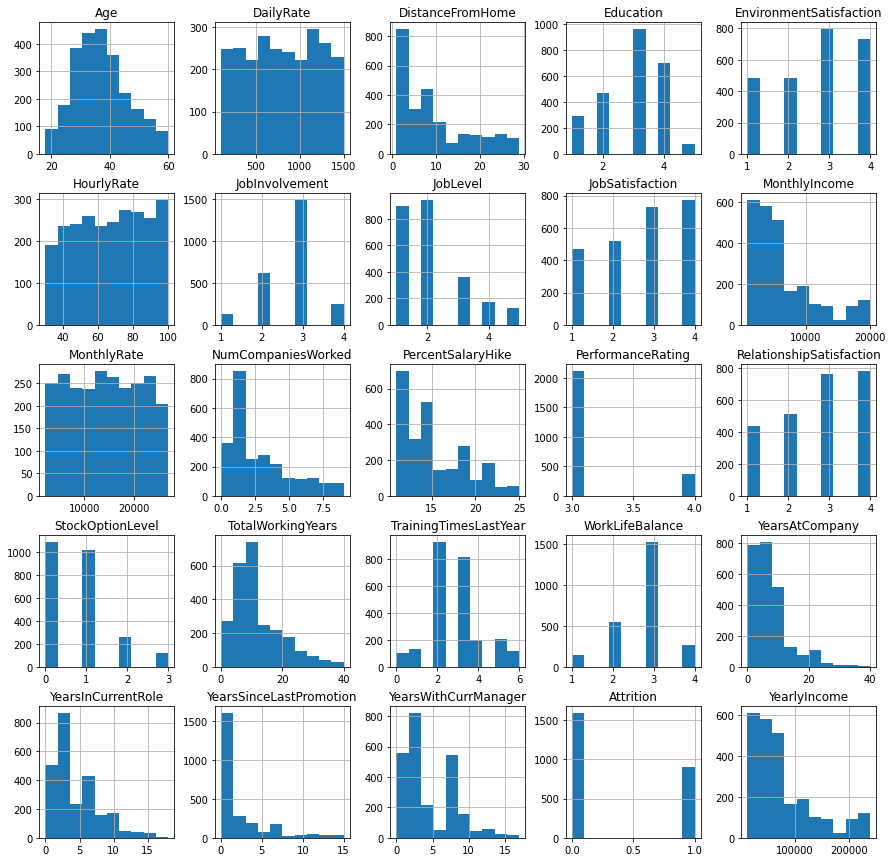

In [29]:
import matplotlib.pyplot as plt
df.hist(figsize=(15,15))
plt.show()

<AxesSubplot:>

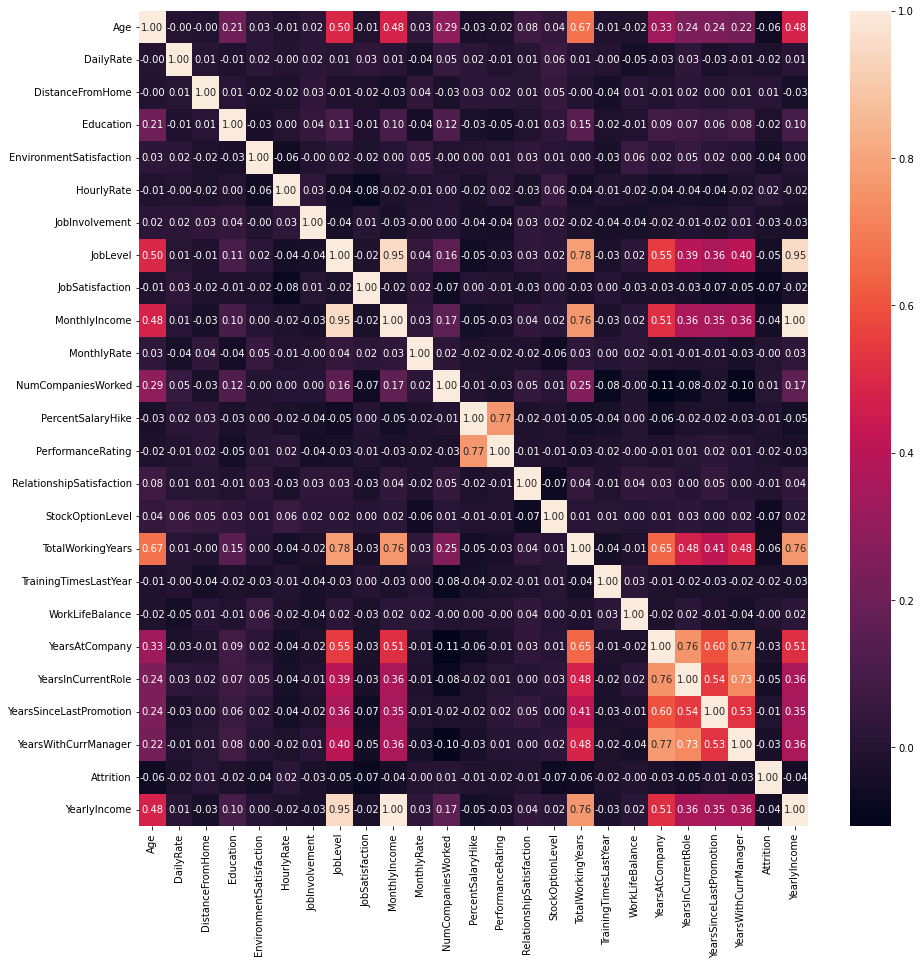

In [30]:
dfc = df.corr()

import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(dfc, annot=True, fmt=".2f")

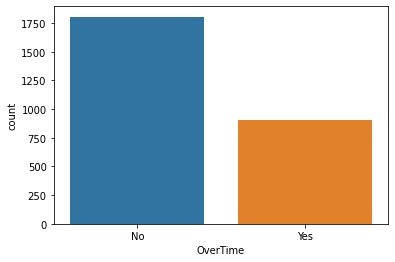

In [37]:
sns.countplot(data=df, x="Attrition")
plt.show()

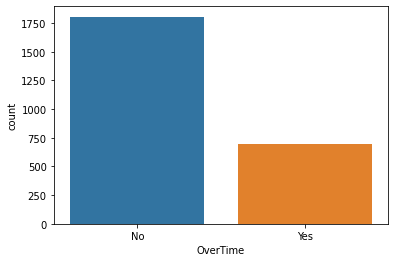

In [38]:
sns.countplot(data=df, x="OverTime")
plt.show()

In [57]:
gr1 = df.groupby("Gender")["Attrition"].value_counts()
gr1

Gender  Attrition
Female  0            629
        1            341
Male    0            965
        1            563
Name: Attrition, dtype: int64

## DecisionTreeClassifier

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import src.helping_functions as hf

target = "Attrition" 
features = df.drop("Attrition", axis=1).columns

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# build pipelines
num_attr = X.select_dtypes(include='number').columns
cat_attr = X.select_dtypes(exclude='number').columns

numeric_pipeline = Pipeline(
    [
        ("std_scaler", StandardScaler()),
    ]
)

category_pipeline = Pipeline(
    [
        ('ohe', OneHotEncoder())
    ]
)

full_pipeline = ColumnTransformer(
    [
        ("numerical", numeric_pipeline, num_attr),
        ("categorical", category_pipeline, cat_attr)
    ]
)

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
model.fit(X_train, y_train)

y_pred_tr = model.predict(X_train)
y_pred_ts = model.predict(X_test)

hf.print_classification_report(y_train, y_pred_tr, y_test, y_pred_ts)
# hf.plot_conf_matrix(y_train, y_pred_tr, y_test, y_pred_ts)


train classification report
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1257
           1       0.84      0.67      0.75       741

    accuracy                           0.83      1998
   macro avg       0.83      0.80      0.81      1998
weighted avg       0.83      0.83      0.83      1998


test classification report
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       337
           1       0.32      0.30      0.31       163

    accuracy                           0.56       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.56      0.56      0.56       500



In [60]:
model.tree_.max_depth

27

In [45]:
tree_params = {
    "criterion":("gini", "entropy"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)),
}

from sklearn.model_selection import GridSearchCV

search_tree = GridSearchCV(model, tree_params, cv=5, n_jobs=-1, verbose=1, scoring="f1")

In [46]:
search_tree.fit(X_train, y_train)

Fitting 5 folds for each of 2166 candidates, totalling 10830 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1', verbose=1)

In [47]:
search_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 18,
 'min_samples_split': 2}

In [48]:
model_1 = search_tree.best_estimator_
model_1.fit(X_train, y_train)

y_pred_tr = model_1.predict(X_train)
y_pred_ts = model_1.predict(X_test)

hf.print_classification_report(y_train, y_pred_tr, y_test, y_pred_ts)
# hf.plot_conf_matrix(y_train, y_pred_tr, y_test, y_pred_ts)

train classification report
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1257
           1       0.66      0.47      0.55       741

    accuracy                           0.71      1998
   macro avg       0.70      0.66      0.67      1998
weighted avg       0.71      0.71      0.70      1998


test classification report
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       337
           1       0.34      0.25      0.29       163

    accuracy                           0.60       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.57      0.60      0.58       500

